In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import glob

In [2]:
sys.path.append('..')

In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_icenode_uniform2lr import ICENODE as ICENODE_UNIFORM
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [4]:
from icenode.utils import load_config, load_params


HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'


def get_trained_params(trained_dir, criterion, comp):
    params = {}
    for clf, clf_dir in trained_dir.items():
        csv_files =  glob.glob(f'{clf_dir}/*.csv', recursive=False)
        dfs = [pd.read_csv(csv_file, index_col=[0]) for csv_file in csv_files]
        max_i = comp(range(len(dfs)), key=lambda i: dfs[i].loc[criterion, 'VAL'])
        csv_file = csv_files[max_i]
        prefix = csv_file.split('_')
        prefix[-1] = 'params.pickle'
        params_file = '_'.join(prefix)
        params[clf] = load_params(params_file)
    return params

        
model_cls = {
    'ICENODE': ICENODE,
    'GRU': GRAM,
    'RETAIN': RETAIN
}       
        
m3_trained_dir = {
    'ICENODE': 
    f'{HOME}/GP/ehr-data/icenode-m3-exp/config_exp_v0.2.25_icenode_2lr_opt_config_M3',
    'GRU': 
    f'{HOME}/GP/ehr-data/icenode-m3-exp/config_exp_v0.2.25_gru_opt_config_M3',
    'RETAIN': 
    f'{HOME}/GP/ehr-data/icenode-m3-exp/config_exp_v0.2.25_retain_opt_config_M3'
}

m3_params = get_trained_params(m3_trained_dir, 'MICRO-AUC', comp=max)

## Patient Interface MIMIC-III

In [5]:
m3_timestamped_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')
m3_sequential_interface = GRAM.create_patient_interface(mimic3_dir, 'M3')

m3_interface = {
    'ICENODE': m3_timestamped_interface,
    'GRU': m3_sequential_interface,
    'RETAIN': m3_sequential_interface
}

## Dataset Partitioning

In [6]:
m3_train_ids, m3_valid_ids, m3_test_ids = m3_timestamped_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)

## Load Config/Params

In [7]:
config = {clf: load_config(f'{train_dir}/config.json') for clf, train_dir in m3_trained_dir.items()}

## Load Models

In [8]:
def get_model_eval(model_cls, config, interface, train_ids, params):
    model = model_cls.create_model(config, interface, train_ids, None)
    state = model.init_with_params(config, params)
    return lambda ids: model.eval(state, ids)['diag_detectability']

m3_model = {clf: get_model_eval(model_cls[clf], config[clf], m3_interface[clf], m3_train_ids, m3_params[clf])
           for clf in m3_trained_dir}

## Per-code performance

In [9]:
from icenode.metrics import codes_auc_pairwise_tests

In [10]:
test_res = {clf: model(m3_test_ids) for clf, model in m3_model.items()} 

In [11]:
tests_raw = codes_auc_pairwise_tests(test_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [01:01<00:00,  3.94it/s]


## Correlation between AUC and N_POS_CODES

In [12]:
tests_raw_auc_corr = tests_raw[[f'AUC({clf})' for clf in test_res] + ['N_POSITIVE_CODES']]
# sns.pairplot(tests_raw_auc_corr)

In [13]:
flatccs_idx2code = {idx: code for code, idx in m3_timestamped_interface.diag_flatccs_idx.items()}
idx2desc = lambda i: m3_timestamped_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
tests_raw['DESC'] = tests_raw['CODE_INDEX'].apply(idx2desc)
tests_raw

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
0,0,4.0,0.687065,0.557463,0.648259,0.016953,0.031096,0.025569,0.086735,0.565084,0.055660,No DX
1,1,17.0,0.541627,0.664967,0.654649,0.005602,0.004773,0.003805,0.131543,0.024450,0.880085,Tuberculosis
2,2,88.0,0.779328,0.785892,0.791309,0.000776,0.000784,0.000784,0.628694,0.300350,0.709598,Immuniz/scrn
3,3,370.0,0.893025,0.894235,0.892391,0.000121,0.000118,0.000123,0.829558,0.903810,0.778590,Acute MI
4,4,18.0,0.720765,0.676365,0.688194,0.004037,0.003645,0.004389,0.426592,0.309803,0.849577,Coron athero
...,...,...,...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.708359,0.729033,0.719172,0.000542,0.000463,0.000512,0.147427,0.364192,0.456712,2ndary malig
179,179,146.0,0.812064,0.815394,0.821930,0.000457,0.000459,0.000464,0.784037,0.272167,0.594779,Malig neopls
180,180,63.0,0.773801,0.771653,0.795144,0.001118,0.001324,0.001197,0.910260,0.172139,0.217504,Neoplsm unsp
181,181,393.0,0.753071,0.795909,0.783126,0.000239,0.000202,0.000221,0.000059,0.000190,0.134757,Maint chem/r


In [126]:
# remove codes that no classifier has scored above 0.7
at_least_AUC_07 = tests_raw.loc[:,[f'AUC({clf})' for clf in test_res]].max(axis=1) > 0.65
tests = tests_raw[at_least_AUC_07]
tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
0,0,4.0,0.687065,0.557463,0.648259,0.016953,0.031096,0.025569,0.086735,0.565084,0.055660,No DX
1,1,17.0,0.541627,0.664967,0.654649,0.005602,0.004773,0.003805,0.131543,0.024450,0.880085,Tuberculosis
2,2,88.0,0.779328,0.785892,0.791309,0.000776,0.000784,0.000784,0.628694,0.300350,0.709598,Immuniz/scrn
3,3,370.0,0.893025,0.894235,0.892391,0.000121,0.000118,0.000123,0.829558,0.903810,0.778590,Acute MI
4,4,18.0,0.720765,0.676365,0.688194,0.004037,0.003645,0.004389,0.426592,0.309803,0.849577,Coron athero
...,...,...,...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.708359,0.729033,0.719172,0.000542,0.000463,0.000512,0.147427,0.364192,0.456712,2ndary malig
179,179,146.0,0.812064,0.815394,0.821930,0.000457,0.000459,0.000464,0.784037,0.272167,0.594779,Malig neopls
180,180,63.0,0.773801,0.771653,0.795144,0.001118,0.001324,0.001197,0.910260,0.172139,0.217504,Neoplsm unsp
181,181,393.0,0.753071,0.795909,0.783126,0.000239,0.000202,0.000221,0.000059,0.000190,0.134757,Maint chem/r


In [128]:
tests.describe()

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN)
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02
mean,91.402778,60.083332,0.774958,0.781193,0.782220,0.005490,0.005269,0.005389,3.591842e-01,3.557828e-01,4.287895e-01
std,54.333124,81.958565,0.115232,0.110959,0.119391,0.009654,0.009243,0.009008,3.005619e-01,2.939765e-01,3.103272e-01
min,0.000000,2.000000,0.541627,0.326216,0.191658,0.000000,0.000000,0.000000,1.936513e-09,3.050465e-07,3.641092e-12
25%,43.750000,9.000000,0.685617,0.702617,0.694590,0.000638,0.000659,0.000621,9.731527e-02,9.332505e-02,1.522887e-01
50%,92.000000,23.500000,0.779317,0.784577,0.789405,0.001805,0.001740,0.001848,2.719080e-01,2.979330e-01,3.749256e-01
75%,138.250000,77.250000,0.859388,0.852089,0.863406,0.004861,0.004867,0.004915,6.421742e-01,5.890344e-01,6.698927e-01
max,182.000000,393.000000,1.000000,1.000000,1.000000,0.067161,0.047826,0.053965,1.000000e+00,1.000000e+00,1.000000e+00


In [95]:
from collections import defaultdict
auc_sets = defaultdict(set)
clfs = tuple(sorted(m3_model.keys()))
clfs_pairs = []
for i in range(len(clfs)):
    for j in range(i + 1, len(clfs)):
        clfs_pairs.append((clfs[i], clfs[j]))
clfs_pairs = tuple(sorted(clfs_pairs))

In [96]:
# Extract codes that are predicted with equivalent performance with all classifiers.
test_cols = tuple(f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs)

In [97]:
common_perf = tests[(tests[test_cols[0]] > 0.05) & (tests[test_cols[1]] > 0.05) & (tests[test_cols[2]] > 0.05)]
auc_sets[clfs] = set(common_perf.CODE_INDEX)

In [98]:
common_perf

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
0,0,4.0,0.687065,0.557463,0.648259,0.016953,0.031096,0.025569,0.086735,0.565084,0.055660,No DX
2,2,88.0,0.779328,0.785892,0.791309,0.000776,0.000784,0.000784,0.628694,0.300350,0.709598,Immuniz/scrn
3,3,370.0,0.893025,0.894235,0.892391,0.000121,0.000118,0.000123,0.829558,0.903810,0.778590,Acute MI
4,4,18.0,0.720765,0.676365,0.688194,0.004037,0.003645,0.004389,0.426592,0.309803,0.849577,Coron athero
8,8,337.0,0.792590,0.806066,0.806720,0.000246,0.000235,0.000241,0.103630,0.057907,0.935856,Conduction
...,...,...,...,...,...,...,...,...,...,...,...,...
174,174,16.0,0.714816,0.790345,0.770770,0.003679,0.002997,0.005264,0.064233,0.355594,0.734006,Leukemias
176,176,3.0,0.649105,0.758781,0.647117,0.025753,0.012372,0.053965,0.229285,0.982318,0.535036,Mult myeloma
178,178,193.0,0.708359,0.729033,0.719172,0.000542,0.000463,0.000512,0.147427,0.364192,0.456712,2ndary malig
179,179,146.0,0.812064,0.815394,0.821930,0.000457,0.000459,0.000464,0.784037,0.272167,0.594779,Malig neopls


In [99]:
competing_tests = tests.drop(index=common_perf.index)

In [100]:
for index, row in competing_tests.iterrows():
    max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
    relevant_tests = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs if max_auc_clf in (clf1, clf2)}
    
    significant_max = True
    for (clf1, clf2), test_col in relevant_tests.items():
        # If max_auc_clf has maximum AUC, but without insigificant difference with another classifier
        # then consider both outperforming the third classifier.
        if row[test_col] > 0.05:
            significant_max = False
            auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))
    
    if significant_max:
        auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))

In [101]:
# Prepare for using Upset plot

best_sets = {}
for clf in clfs:
    best_sets[clf] = auc_sets[clf] | auc_sets[clfs]
    for clf1, clf2 in clfs_pairs:
        if clf in (clf1, clf2):
            best_sets[clf].update(auc_sets[(clf1, clf2)])
    

In [102]:
from upsetplot import from_contents, plot, UpSet
import matplotlib.pyplot as plt

In [103]:
upset_contents = from_contents(best_sets)

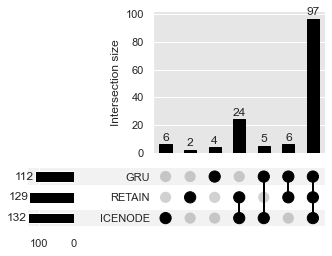

In [282]:
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
current_figure = plt.gcf()
current_figure.savefig("auc_upset.pdf")

plt.show()


In [26]:
model_best_tests = {clf: competing_tests[competing_tests['CODE_INDEX'].isin(best_sets[clf])] for clf in clfs}
model_exc_best_tests = {clf: competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets[clf])] for clf in clfs}

In [27]:
from IPython.display import display

for clf, best_tests in model_best_tests.items():
    print(clf)
    display(best_tests)

GRU


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
7,7,111.0,0.906910,0.882983,0.910512,0.000212,0.000284,0.000219,6.392821e-02,0.588049,3.953195e-02,Oth heart dx
10,10,353.0,0.848282,0.858262,0.835275,0.000159,0.000154,0.000172,1.643327e-01,0.047707,2.309609e-03,Cardia arrst
14,14,27.0,0.779305,0.792977,0.757091,0.003245,0.003721,0.004238,4.725242e-01,0.233412,1.760182e-02,Precere occl
19,19,8.0,0.633492,0.700050,0.519231,0.009902,0.004563,0.014704,2.884267e-01,0.006471,2.368479e-02,Aneurysm
22,22,2.0,0.939921,0.780536,0.860477,0.001987,0.020832,0.018696,1.119129e-01,0.390987,3.641092e-12,Phlebitis
27,27,2.0,0.977656,0.870904,0.871400,0.000027,0.001303,0.002601,1.517998e-03,0.028061,9.785895e-01,Pneumonia
39,39,2.0,0.785501,0.326216,0.191658,0.005387,0.000223,0.018866,1.936513e-09,0.004664,3.193404e-01,Oth low resp
52,52,10.0,0.869770,0.565265,0.785586,0.003194,0.006630,0.004362,1.125193e-04,0.000002,7.038663e-03,Int obstruct
93,93,3.0,0.579192,0.629887,0.871107,0.021117,0.005189,0.003444,5.062749e-01,0.095194,1.951132e-02,HTN in preg
111,111,10.0,0.847948,0.612212,0.789389,0.001583,0.004817,0.004385,2.307464e-05,0.125053,2.224370e-02,Septicemia


ICENODE


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
5,5,77.0,0.678753,0.708963,0.730882,0.001209,0.001093,0.001018,0.229761,0.007313,2.749040e-01,Chest pain
10,10,353.0,0.848282,0.858262,0.835275,0.000159,0.000154,0.000172,0.164333,0.047707,2.309609e-03,Cardia arrst
14,14,27.0,0.779305,0.792977,0.757091,0.003245,0.003721,0.004238,0.472524,0.233412,1.760182e-02,Precere occl
18,18,43.0,0.748652,0.816939,0.800388,0.002080,0.001369,0.001606,0.023721,0.013310,3.736743e-01,Perip athero
19,19,8.0,0.633492,0.700050,0.519231,0.009902,0.004563,0.014704,0.288427,0.006471,2.368479e-02,Aneurysm
22,22,2.0,0.939921,0.780536,0.860477,0.001987,0.020832,0.018696,0.111913,0.390987,3.641092e-12,Phlebitis
28,28,5.0,0.702689,0.776693,0.693725,0.017522,0.017679,0.010810,0.014116,0.919937,3.495510e-01,Influenza
33,33,208.0,0.703202,0.728068,0.729437,0.000410,0.000401,0.000378,0.099017,0.042273,9.196308e-01,Asthma
40,40,197.0,0.751031,0.781926,0.776156,0.000440,0.000377,0.000378,0.028931,0.029460,5.975957e-01,Ot uppr resp
45,45,28.0,0.641000,0.736457,0.679591,0.003773,0.002096,0.003517,0.003541,0.196937,1.231302e-01,Gasduo ulcer


RETAIN


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
5,5,77.0,0.678753,0.708963,0.730882,0.001209,0.001093,0.001018,0.229761,0.007313,2.749040e-01,Chest pain
7,7,111.0,0.906910,0.882983,0.910512,0.000212,0.000284,0.000219,0.063928,0.588049,3.953195e-02,Oth heart dx
18,18,43.0,0.748652,0.816939,0.800388,0.002080,0.001369,0.001606,0.023721,0.013310,3.736743e-01,Perip athero
22,22,2.0,0.939921,0.780536,0.860477,0.001987,0.020832,0.018696,0.111913,0.390987,3.641092e-12,Phlebitis
28,28,5.0,0.702689,0.776693,0.693725,0.017522,0.017679,0.010810,0.014116,0.919937,3.495510e-01,Influenza
33,33,208.0,0.703202,0.728068,0.729437,0.000410,0.000401,0.000378,0.099017,0.042273,9.196308e-01,Asthma
40,40,197.0,0.751031,0.781926,0.776156,0.000440,0.000377,0.000378,0.028931,0.029460,5.975957e-01,Ot uppr resp
45,45,28.0,0.641000,0.736457,0.679591,0.003773,0.002096,0.003517,0.003541,0.196937,1.231302e-01,Gasduo ulcer
49,49,3.0,0.645461,0.788933,0.853545,0.027915,0.015672,0.005469,0.288256,0.044295,3.698612e-01,Appendicitis
57,57,135.0,0.692313,0.732621,0.700856,0.000806,0.000679,0.000720,0.020035,0.537062,6.253537e-02,Rctm/anus ca


In [28]:
for clf, best_tests in model_exc_best_tests.items():
    print(clf)
    display(best_tests)

GRU


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
27,27,2.0,0.977656,0.870904,0.871400,0.000027,0.001303,0.002601,1.517998e-03,0.028061,0.978589,Pneumonia
39,39,2.0,0.785501,0.326216,0.191658,0.005387,0.000223,0.018866,1.936513e-09,0.004664,0.319340,Oth low resp
52,52,10.0,0.869770,0.565265,0.785586,0.003194,0.006630,0.004362,1.125193e-04,0.000002,0.007039,Int obstruct
177,177,8.0,0.705420,0.567433,0.557817,0.007483,0.012081,0.007212,1.520919e-02,0.018649,0.879181,Ot primry ca


ICENODE


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
47,47,20.0,0.654752,0.772245,0.657533,0.003381,0.001740,0.003877,0.028041,0.954490,0.029244,Gastritis
60,60,232.0,0.871572,0.893706,0.876869,0.000176,0.000155,0.000167,0.014295,0.404418,0.047915,GI hemorrhag
167,167,21.0,0.716888,0.815500,0.731396,0.005042,0.002220,0.003622,0.033652,0.591990,0.048484,Bladder cncr


RETAIN


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
139,139,60.0,0.853433,0.815560,0.890929,0.000732,0.001188,0.000430,0.026638,0.045008,0.002234,Ot perint dx
156,156,75.0,0.941185,0.941799,0.956488,0.000366,0.000288,0.000197,0.901322,0.025388,0.038471,Uterus cancr


In [29]:
icenode_best_tests = model_best_tests['ICENODE']
icenode_best_test_above07 = icenode_best_tests[icenode_best_tests['AUC(ICENODE)'] > 0.7]
icenode_best_test_above07

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
5,5,77.0,0.678753,0.708963,0.730882,0.001209,0.001093,0.001018,0.229761,0.007313,2.749040e-01,Chest pain
10,10,353.0,0.848282,0.858262,0.835275,0.000159,0.000154,0.000172,0.164333,0.047707,2.309609e-03,Cardia arrst
14,14,27.0,0.779305,0.792977,0.757091,0.003245,0.003721,0.004238,0.472524,0.233412,1.760182e-02,Precere occl
18,18,43.0,0.748652,0.816939,0.800388,0.002080,0.001369,0.001606,0.023721,0.013310,3.736743e-01,Perip athero
19,19,8.0,0.633492,0.700050,0.519231,0.009902,0.004563,0.014704,0.288427,0.006471,2.368479e-02,Aneurysm
22,22,2.0,0.939921,0.780536,0.860477,0.001987,0.020832,0.018696,0.111913,0.390987,3.641092e-12,Phlebitis
28,28,5.0,0.702689,0.776693,0.693725,0.017522,0.017679,0.010810,0.014116,0.919937,3.495510e-01,Influenza
33,33,208.0,0.703202,0.728068,0.729437,0.000410,0.000401,0.000378,0.099017,0.042273,9.196308e-01,Asthma
40,40,197.0,0.751031,0.781926,0.776156,0.000440,0.000377,0.000378,0.028931,0.029460,5.975957e-01,Ot uppr resp
45,45,28.0,0.641000,0.736457,0.679591,0.003773,0.002096,0.003517,0.003541,0.196937,1.231302e-01,Gasduo ulcer


## AUC Distribution

In [287]:
df = common_perf[['AUC(ICENODE)', 'DESC', 'VAR[AUC(ICENODE)]']].sort_values('AUC(ICENODE)')
df = df[df['AUC(ICENODE)'] > 0.65]
df.columns = ['AUC', 'CCS', 'VAR']
error = df['VAR'].apply(np.sqrt)

In [288]:
len(df)

89

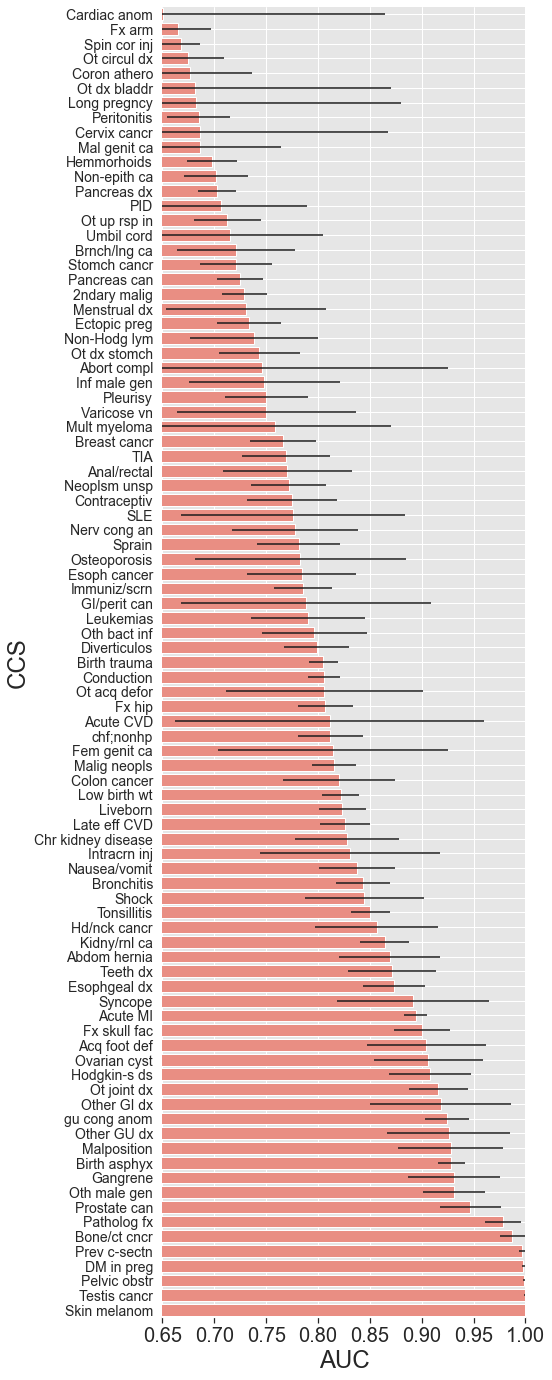

In [290]:
fig, ax = plt.subplots(figsize=(8,20))
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax = sns.barplot(x="AUC", y="CCS", color="salmon", xerr=error*1,capsize=.2, data=df)
# plt.title('ICE-NODE AUC on CCS Codes of Comparable AUC with GRU/RETAIN', fontsize=20)

fig.tight_layout(pad=4)
plt.xlabel('AUC', fontsize=24)
plt.xlim(0.65, 1.0)
plt.xticks(fontsize=20)

plt.ylabel('CCS', fontsize=24)
plt.yticks(fontsize=14)

sns.despine(left=True)
ax.grid(True)
ax.tick_params(bottom=True, left=False)

current_figure = plt.gcf()
current_figure.savefig("common_performance.pdf")


plt.show()

In [297]:
competing_df = []
comp_tests = competing_tests[competing_tests[[f'AUC({clf})' for clf in clfs]].max(axis=1) > 0.7]

for clf in clfs:
    comp_auc = comp_tests[f'AUC({clf})']
    comp_var = comp_tests[f'VAR[AUC({clf})]']
    comp_std = comp_var.apply(np.sqrt)
    comp_desc = comp_tests['DESC'].apply(lambda t: t if len(t) < 15 else t[:14] + '...')
    df = pd.DataFrame({'AUC': comp_auc, 'std': comp_std, 'CCS': comp_desc, 'Classifier': clf})
    df = df.sort_values('AUC').reset_index(drop=True)
    competing_df.append(df)

competing_df = pd.concat(competing_df)

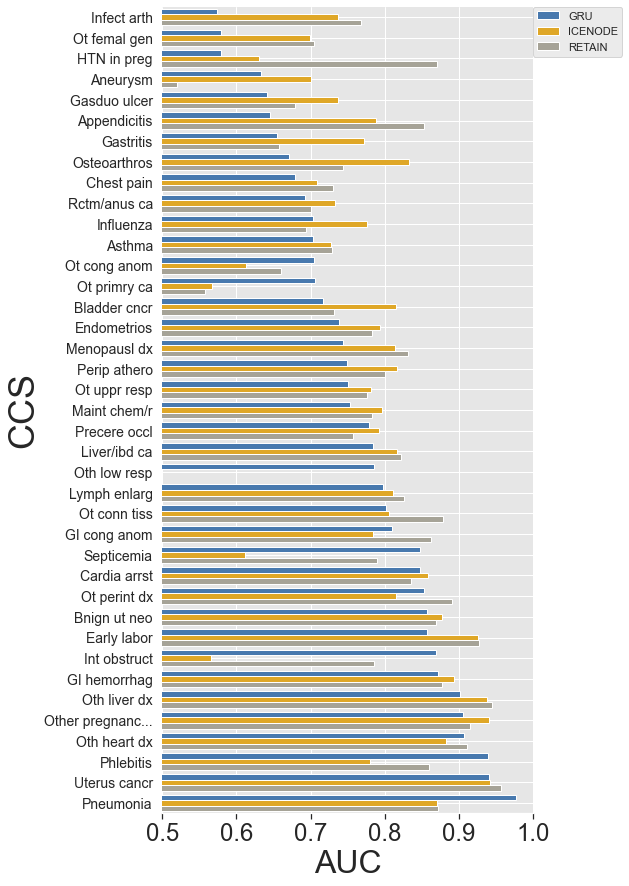

In [309]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
colors = sns.xkcd_palette(["windows blue", "amber", "greyish"])

ax = sns.barplot(x="AUC", y="CCS", hue='Classifier', palette =colors , data=competing_df)
# plt.title('Performance of ICE-NODE/GRU/RETAIN', fontsize=40)

fig.tight_layout(pad=10)
plt.xlabel('AUC', fontsize=32)
plt.xlim(0.5, 1.0)
plt.xticks(fontsize=24)
plt.yticks(fontsize=14)

plt.ylabel('CCS', fontsize=36)
plt.legend(fontsize='xx-large', title_fontsize='40')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.despine(left=True)
ax.grid(True)
ax.tick_params(bottom=True, left=False)
current_figure = plt.gcf()
current_figure.savefig("competing_performance.pdf")

plt.show()


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [ ]:
icenode_visit_auc_df = icenode.admissions_auc_scores(icenode_state, test_ids)

In [ ]:
icenode_visit_auc_df['N_VISITS'] = icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
icenode_visit_auc_df

In [ ]:
visit_auc_subject = icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean', 'max', 'min'], 'R/T': ['min', 'max', 'mean'] })


In [ ]:
best_visit_auc_subjects =  visit_auc_subject[(visit_auc_subject.AUC['mean'] > 0.7) & (visit_auc_subject.N_VISITS['max'] > 1) & (visit_auc_subject.N_VISITS['max'] <10) & (visit_auc_subject.INTERVALS['max'] < 90)]
best_visit_auc_subjects

In [ ]:
ccs_history = {i: icnode_patient_interface.diag_flatccs_history(i)[1] for i in best_visit_auc_subjects.index}

In [ ]:
ccs_history_icenode_best = {i: history for i, history in ccs_history.items() if len(set(history) & set(icenode_best_test_above07['CODE_INDEX']))> 0}

In [ ]:
ccs_history_icenode_best

In [ ]:
len(ccs_history_icenode_best)

In [ ]:
trajectory = icenode.sample_trajectory(icenode_state, ccs_history_icenode_best.keys(), 1)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ccs_index = list(icenode_best_test_above07['CODE_INDEX'])
idx2desc = lambda idx: icnode_patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[idx]]
ccs_description = list(map(idx2desc, ccs_index))


In [ ]:
data = {}
for i, traj in trajectory.items():
    diag_times = icnode_patient_interface.diag_times(i)
    
    t = traj['t']
    d = traj['d']
    
    prob = []
    time = []
    code = []
    
    for ccs_desc, ccs_idx in zip(ccs_description, ccs_index):
        time.append(t)
        code.extend([ccs_desc]*len(t))
        prob.append(d[:, ccs_idx])

    prob = np.hstack(prob)
    time = np.hstack(time)
    
    
    df = pd.DataFrame({'t': time, r'$\hat{v}$': prob, 'code': code})
    data[i] = (df, diag_times)
    

In [ ]:
plt.rcParams['figure.figsize']=(10,10)
import math
for i, (df, diag_times) in data.items():

    plt.figure(i)
    
    g = sns.lineplot(data=df, x="t", y=r'$\hat{v}$', hue='code', marker='o')
    for diag_time in diag_times:
        g.axvline(x=diag_time, ymin=0, ymax=1, c="red", ls='--', linewidth=0.8, zorder=0, clip_on=False)

It seems that we cannot catch the smoothness of the trajectory as it evolves very quickly to the saturation value.